<a href="https://colab.research.google.com/github/Anum-Ilyas9/PR/blob/main/PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandapower
!pip install kaggle
!pip install pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


Dataset URL: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
License(s): DbCL-1.0
  0% 0.00/19.4M [00:00<?, ?B/s]
100% 19.4M/19.4M [00:00<00:00, 427MB/s]
✅ Load dataset downloaded and extracted successfully.
🔵 Enter the date for simulation (YYYY-MM-DD): 2009-07-17
✅ Load profile for 2009-07-17 selected.
✅ IEEE 33-bus distribution system created.
✅ Distributed Solar (DSG) and Wind (DWG) Generators integrated.
⚡ Fault injected at Hour 10 to simulate undervoltage.
⚡ Fault injected at Hour 15 to simulate undervoltage.

✅ Time-series simulation for 2009-07-17 completed successfully.

Actual Faults    : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted Faults : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

📊 Fault Detection Evaluation Metrics:
Accuracy : 1.00
Precision: 1.00
Recall   : 1.00
F1 Score : 1.00

📈 Plotting simulation results for 2009-07-17...


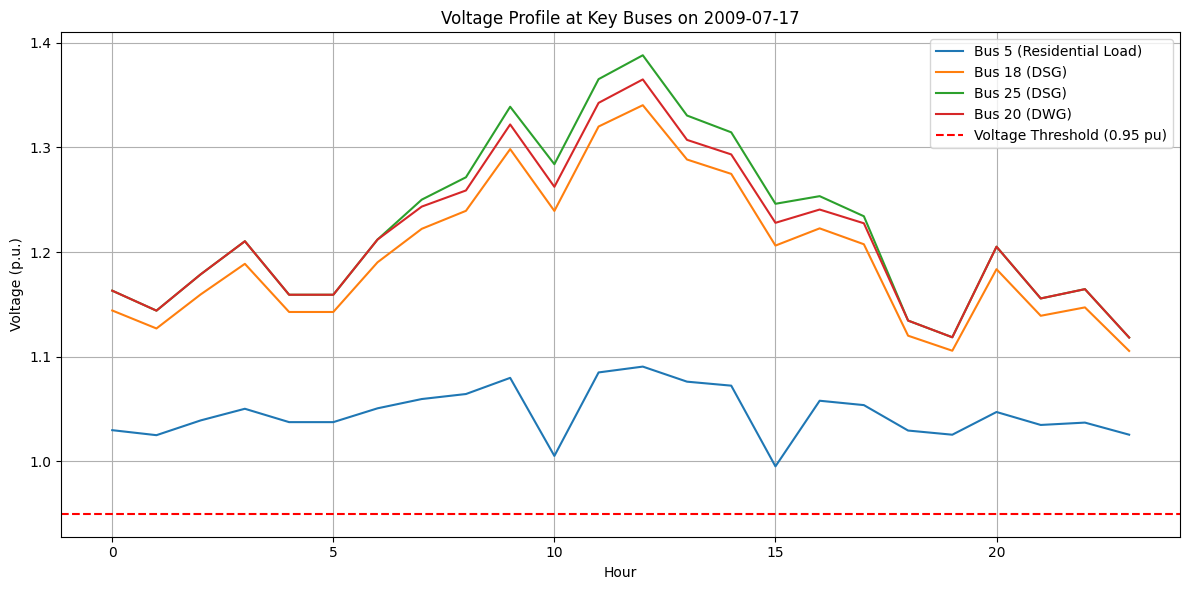

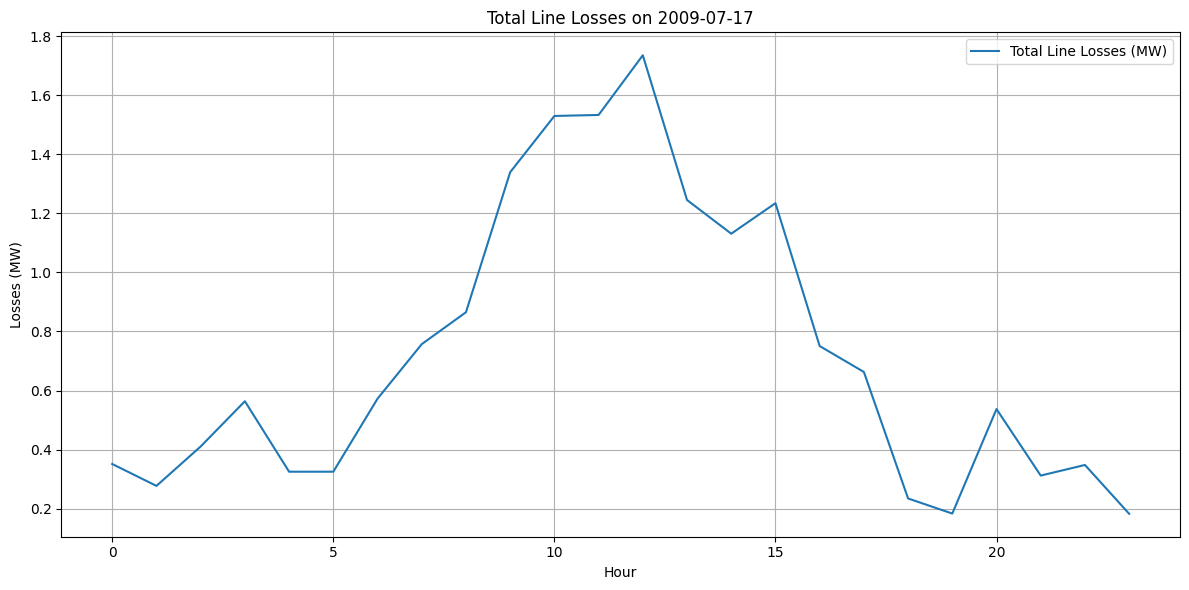

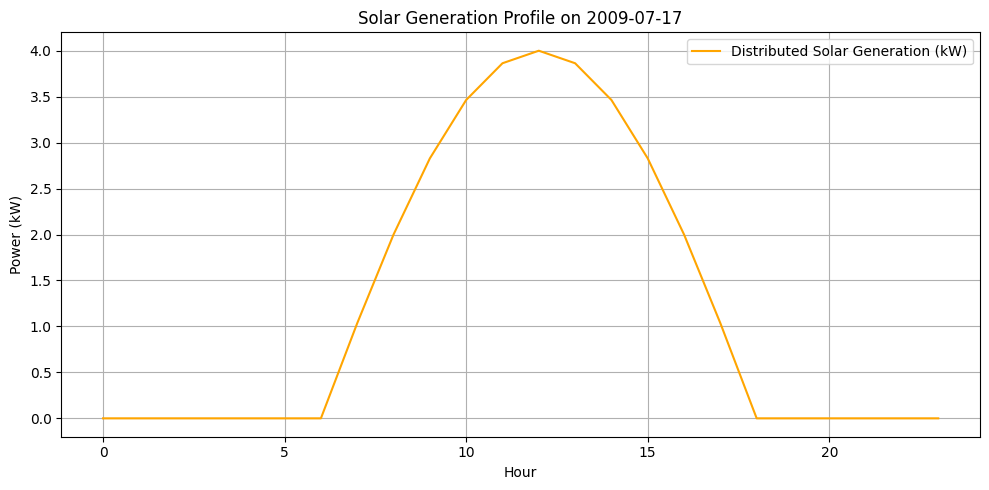

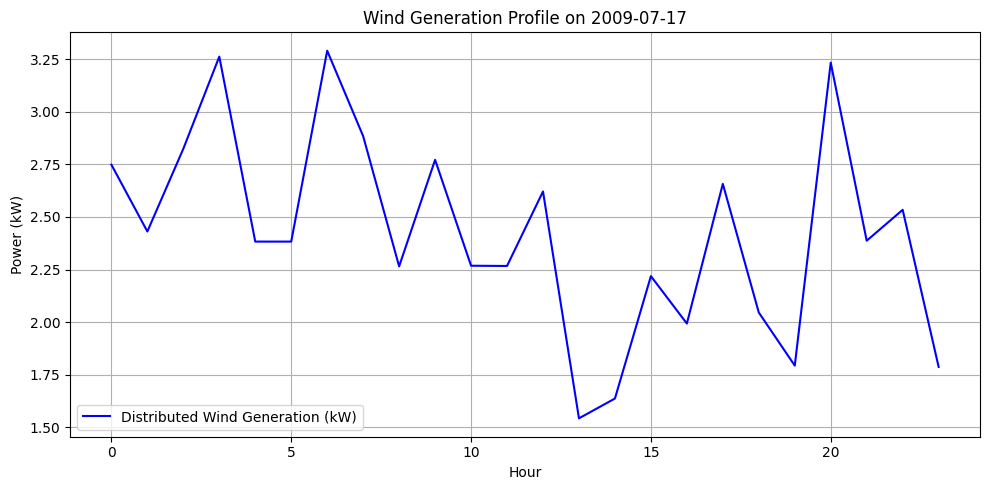

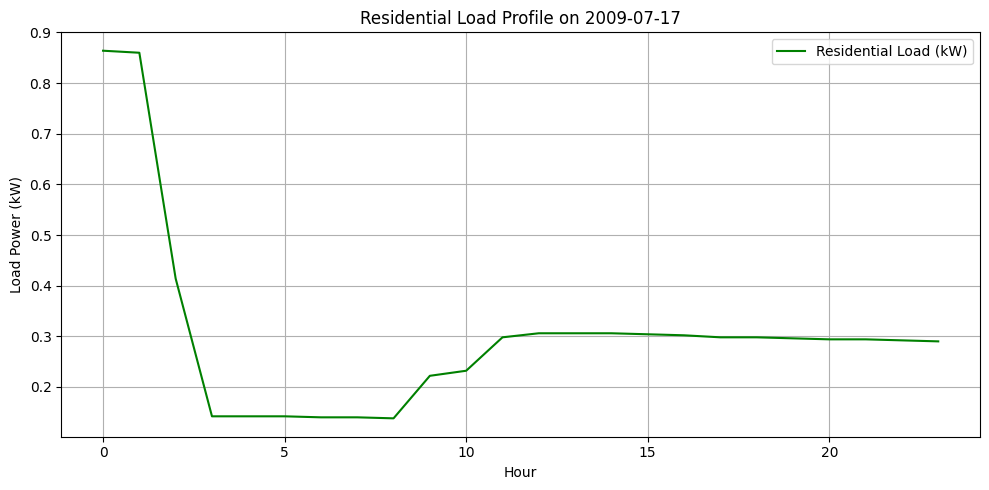

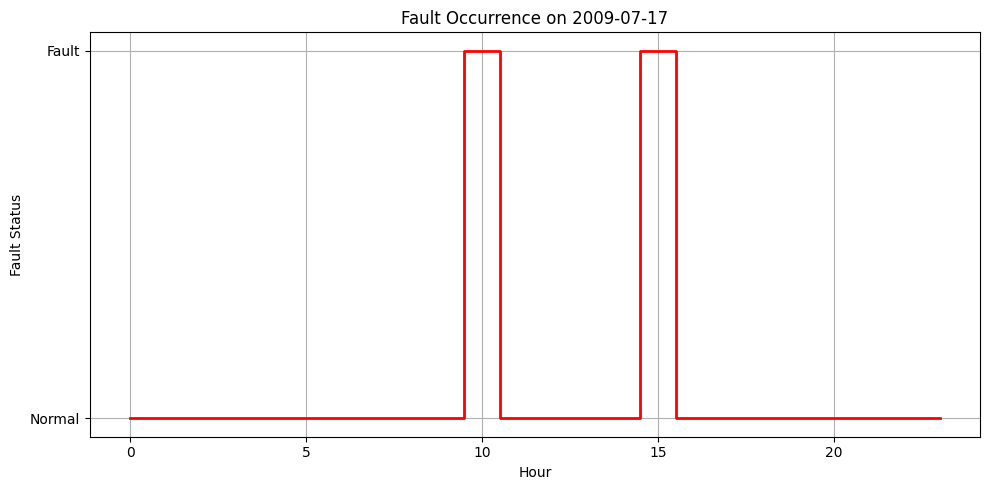

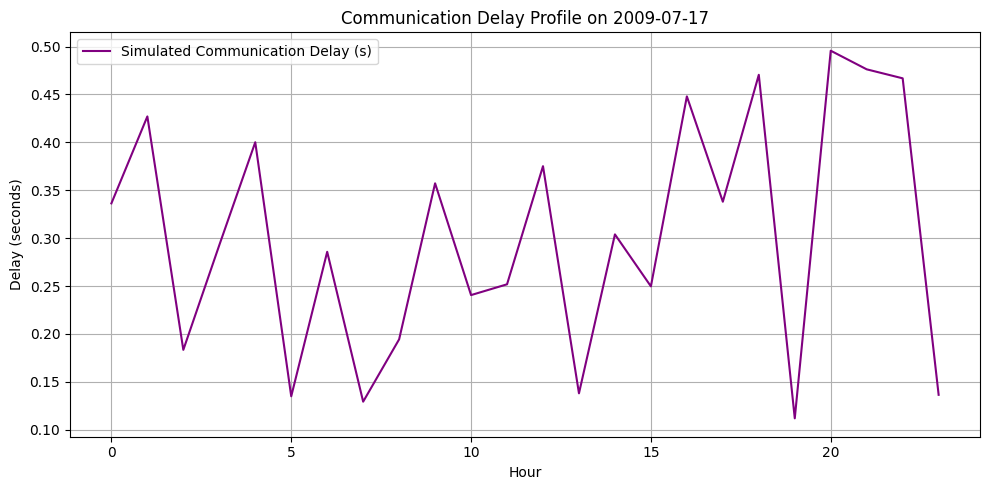


✅ All graphs for 2009-07-17 generated successfully.


In [2]:
# -------------------- Setup Environment --------------------
import os
import zipfile
import pandas as pd
import numpy as np
import pandapower as pp
import matplotlib.pyplot as plt
import time
import random


# -------------------- Kaggle Dataset Setup --------------------
KAGGLE_USERNAME = "YOUR_KAGGLE_USERNAME"
KAGGLE_KEY = "YOUR_KAGGLE_API_KEY"

os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    f.write('{"username":"' + KAGGLE_USERNAME + '","key":"' + KAGGLE_KEY + '"}')
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d uciml/electric-power-consumption-data-set

dataset_zip_path = 'electric-power-consumption-data-set.zip'
dataset_extract_path = './ElectricityDataset'
if not os.path.exists(dataset_extract_path):
    os.makedirs(dataset_extract_path)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)

print("✅ Load dataset downloaded and extracted successfully.")

# -------------------- Load and Prepare Dataset --------------------
load_data = pd.read_csv('./ElectricityDataset/household_power_consumption.txt',
                        sep=';', low_memory=False, na_values='?')
load_data.dropna(inplace=True)
load_data['Global_active_power'] = load_data['Global_active_power'].astype(float)
load_data['Datetime'] = pd.to_datetime(load_data['Date'] + ' ' + load_data['Time'], format='%d/%m/%Y %H:%M:%S')

# User input for simulation date
user_date = input("🔵 Enter the date for simulation (YYYY-MM-DD): ")
try:
    selected_day = pd.to_datetime(user_date).date()
    load_day = load_data[load_data['Datetime'].dt.date == selected_day]
    if load_day.empty:
        raise ValueError
except:
    print("❌ Invalid date or no data available. Please enter a valid date.")
    exit()

load_profile = load_day['Global_active_power'].reset_index(drop=True)
print(f"✅ Load profile for {selected_day} selected.")

# -------------------- Create IEEE 33-Bus System --------------------
net = pp.create_empty_network()

buses = [pp.create_bus(net, vn_kv=12.66, name=f"Bus {i}") for i in range(34)]

pp.create_ext_grid(net, bus=buses[0], vm_pu=1.0)

for i in range(33):
    pp.create_line_from_parameters(
        net,
        from_bus=buses[i],
        to_bus=buses[i+1],
        length_km=1.0,
        r_ohm_per_km=0.642,
        x_ohm_per_km=0.083,
        c_nf_per_km=0,
        max_i_ka=1.0
    )

residential_buses = [5, 6, 7, 8, 9, 10]
for bus in residential_buses:
    pp.create_load(net, bus=bus, p_mw=0.1, q_mvar=0.05)

pp.create_switch(net, bus=buses[12], element=buses[22], et="b", closed=False)

print("✅ IEEE 33-bus distribution system created.")

# -------------------- Distributed Generation Profiles --------------------
hours = np.arange(0, 24)
solar_profile = pd.Series(np.clip(np.sin((hours - 6) * np.pi / 12), 0, 1) * 4)
np.random.seed(42)
wind_profile = np.clip(np.random.normal(loc=2.5, scale=0.5, size=24), 0, 4)

# Assign Distributed Solar and Wind Generators
pp.create_sgen(net, bus=buses[18], p_mw=solar_profile.iloc[0] * 0.6, q_mvar=0.0, type='pv')
pp.create_sgen(net, bus=buses[25], p_mw=solar_profile.iloc[0] * 0.4, q_mvar=0.0, type='pv')
pp.create_sgen(net, bus=buses[20], p_mw=wind_profile[0], q_mvar=0.0, type='wind')

print("✅ Distributed Solar (DSG) and Wind (DWG) Generators integrated.")

def simulate_communication_delay(min_delay=0.1, max_delay=0.5):
    delay = random.uniform(min_delay, max_delay)
    time.sleep(delay)
    return delay
# -------------------- Time-Series Simulation --------------------
fault_hours = [10, 15]
results = []
delay_profile = []
for hour in range(24):
    for idx, bus in enumerate(residential_buses):
        net.load.at[idx, 'p_mw'] = load_profile.iloc[hour] / len(residential_buses)

    net.sgen.at[0, 'p_mw'] = solar_profile.iloc[hour] * 0.6
    net.sgen.at[1, 'p_mw'] = solar_profile.iloc[hour] * 0.4
    net.sgen.at[2, 'p_mw'] = wind_profile[hour]

    if hour in fault_hours:
        net.ext_grid.at[0, 'vm_pu'] = 0.92
        print(f"⚡ Fault injected at Hour {hour} to simulate undervoltage.")
    else:
        net.ext_grid.at[0, 'vm_pu'] = 1.0

    pp.runpp(net)

    low_voltage_buses = net.res_bus[net.res_bus.vm_pu < 0.95].index.tolist()
    # Move the delay calculation and append inside the loop
    delay = simulate_communication_delay()
    delay_profile.append(delay) # This line was moved here


    if low_voltage_buses:
        if 5 in low_voltage_buses:
            switch_idx = net.switch.index[0]
            if not net.switch.closed.at[switch_idx]:
                net.switch.at[switch_idx, 'closed'] = True
                print(f"🔧 Self-healing: Tie-switch closed between Bus 12 and Bus 22.")

    results.append({
        'hour': hour,
        'low_voltage_buses': low_voltage_buses,
        'total_losses_mw': net.res_line.pl_mw.sum(),
        'bus5_voltage': net.res_bus.vm_pu.at[buses[5]],
        'bus18_voltage': net.res_bus.vm_pu.at[buses[18]],
        'bus25_voltage': net.res_bus.vm_pu.at[buses[25]],
        'bus20_voltage': net.res_bus.vm_pu.at[buses[20]]
    })


print(f"\n✅ Time-series simulation for {selected_day} completed successfully.")

# -------------------- Plotting Results --------------------
results_df = pd.DataFrame(results)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ground Truth: 1 if fault injected at that hour, else 0
actual_faults = [1 if hour in fault_hours else 0 for hour in range(24)]

# Predicted: 1 if any low voltage bus is detected (simulated fault detection), else 0
predicted_faults = [1 if len(results[i]['low_voltage_buses']) > 0 else 0 for i in range(24)]

# Optional: Display both lists to verify
print("\nActual Faults    :", actual_faults)
print("Predicted Faults :", predicted_faults)

# Compute Metrics
accuracy = accuracy_score(actual_faults, predicted_faults)
precision = precision_score(actual_faults, predicted_faults, zero_division=0)
recall = recall_score(actual_faults, predicted_faults, zero_division=0)
f1 = f1_score(actual_faults, predicted_faults, zero_division=0)

# Display Results
print("\n📊 Fault Detection Evaluation Metrics:")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")



print(f"\n📈 Plotting simulation results for {selected_day}...")

# Voltage Profile
plt.figure(figsize=(12, 6))
plt.plot(results_df['hour'], results_df['bus5_voltage'], label='Bus 5 (Residential Load)')
plt.plot(results_df['hour'], results_df['bus18_voltage'], label='Bus 18 (DSG)')
plt.plot(results_df['hour'], results_df['bus25_voltage'], label='Bus 25 (DSG)')
plt.plot(results_df['hour'], results_df['bus20_voltage'], label='Bus 20 (DWG)')
plt.axhline(0.95, color='red', linestyle='--', label='Voltage Threshold (0.95 pu)')
plt.xlabel('Hour')
plt.ylabel('Voltage (p.u.)')
plt.title(f'Voltage Profile at Key Buses on {selected_day}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Total Losses
plt.figure(figsize=(12, 6))
plt.plot(results_df['hour'], results_df['total_losses_mw'], label='Total Line Losses (MW)')
plt.xlabel('Hour')
plt.ylabel('Losses (MW)')
plt.title(f'Total Line Losses on {selected_day}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Solar Profile
plt.figure(figsize=(10, 5))
plt.plot(hours, solar_profile, label='Distributed Solar Generation (kW)', color='orange')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title(f'Solar Generation Profile on {selected_day}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Wind Profile
plt.figure(figsize=(10, 5))
plt.plot(hours, wind_profile, label='Distributed Wind Generation (kW)', color='blue')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title(f'Wind Generation Profile on {selected_day}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Load Profile
plt.figure(figsize=(10, 5))
plt.plot(hours, load_profile.iloc[:24], label='Residential Load (kW)', color='green')
plt.xlabel('Hour')
plt.ylabel('Load Power (kW)')
plt.title(f'Residential Load Profile on {selected_day}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Fault Occurrence
fault_status = [1 if hour in fault_hours else 0 for hour in range(24)]

plt.figure(figsize=(10, 5))
plt.step(range(24), fault_status, where='mid', color='red', linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Fault Status')
plt.title(f'Fault Occurrence on {selected_day}')
plt.yticks([0, 1], ['Normal', 'Fault'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Communication Delay Profile
plt.figure(figsize=(10, 5))
plt.plot(range(24), delay_profile, label='Simulated Communication Delay (s)', color='purple')
plt.xlabel('Hour')
plt.ylabel('Delay (seconds)')
plt.title(f'Communication Delay Profile on {selected_day}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n✅ All graphs for {selected_day} generated successfully.")
